In [2]:
import itertools
import logging
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import joblib
import sys
from main_model.model.pipeline import *
from main_model.config.read_config import *
from main_model.util.general_normalize import _clean_text
from main_model.util.io_util import *
from distances import get_most_similar_documents

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO


PATH_DICTIONARY = "models/id2word.dictionary"
PATH_CORPUS = "models/corpus.mm"
PATH_LDA_MODEL = "models/LDA.model"
PATH_DOC_TOPIC_DIST = "models/doc_topic_dist.dat"



In [4]:
json_content = read_config_file()
config = read_config_file()
df_extract = read_data(type_data='sql_server', config=config, path_data=None, where_stm='WHERE session_id = \'20230502_22-17-06\'')
df_extract = pre_process_df2(df_extract)
doc_tokenized = [simple_preprocess(doc) for doc in df_extract['clean_content']]
# assume the word 'b' is to be deleted, put its id in a variable
id2word = gensim.corpora.Dictionary(doc_tokenized)
#my_list = ['numbertoken', 'điều', 'và', 'của', 'về', 'có', 'công', 'trình', 'chủ', 'để']
#del_ids = [k for k, v in id2word.items() if v in my_list]
# remove unwanted word ids from the dictionary in place
#id2word.filter_tokens(bad_ids=del_ids)
id2word.filter_extremes(no_below=5, no_above=0.5)
id2word.compactify()

# save dictionary
#id2word.save(PATH_DICTIONARY)
corpus = [id2word.doc2bow(doc) for doc in doc_tokenized]

    #corpus = StreamCorpus(doc_tokenized, id2word)
    # Term Document Frequency
    #corpus = [id2word.doc2bow(text) for text in sentences]
    # save corpus
    #gensim.corpora.MmCorpus.serialize(PATH_CORPUS, corpus)
    # load corpus
    # mm_corpus = gensim.corpora.MmCorpus('path_to_save_file.mm')
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word=id2word)
    # save model
    #lda_model.save(PATH_LDA_MODEL)
    #lda_model.print_topics(-1)
lda_model.show_topics(num_topics=15, num_words=5)
for idx, topic in lda_model.show_topics():
    print('Topic: {} \nWords: {}'.format(idx, ''.join([w[0] for w in topic])))

    # Compute Perplexity
    #print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
    # Compute Coherence Score
    #coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=doc_tokenized, dictionary=id2word, coherence='c_v')
    #coherence_lda = coherence_model_lda.get_coherence()
    #print('\nCoherence Score: ', coherence_lda)

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_tokenized):
        # Init output
    sent_topics_df = pd.DataFrame()

        # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df



path_config_file = D:\Lap trinh\Python\NLP\config_run.json
path_config_file = D:\Lap trinh\Python\NLP\config_run.json
New URI: DRIVER={ODBC Driver 17 for SQL Server};SERVER=.;DATABASE=AI-data;Trusted_Connection=yes;


INFO : adding document #0 to Dictionary<0 unique tokens: []>
INFO : built Dictionary<186 unique tokens: ['chỉnh', 'numbertoken', 'phạm_vi', 'điều', 'dự_án']...> from 237 documents (total 1976 corpus positions)
INFO : Dictionary lifecycle event {'msg': "built Dictionary<186 unique tokens: ['chỉnh', 'numbertoken', 'phạm_vi', 'điều', 'dự_án']...> from 237 documents (total 1976 corpus positions)", 'datetime': '2023-11-04T16:13:57.639653', 'gensim': '4.2.0', 'python': '3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
INFO : discarding 129 tokens: [('numbertoken', 237), ('phạm_vi', 4), ('điều', 237), ('hiệu_lực', 4), ('quy_định', 2), ('tiếp', 4), ('đầu_tư', 143), ('công_khai', 1), ('dõi', 4), ('tra', 1)]...
INFO : keeping 57 tokens which were in no less than 5 and no more than 118 (=50.0%) documents
INFO : resulting dictionary: Dictionary<57 unique tokens: ['chỉnh', 'dự_án', 'phân', 'tiêu_chí', 'thi_hà

TypeError: __init__() got an unexpected keyword argument 'num_words'

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = gensim.models.coherencemodel.CoherenceModel(
            model=model, texts=texts,
            dictionary=dictionary, coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values



In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=doc_tokenized,  start=2, limit=40, step=6)

INFO : using symmetric alpha at 0.5
INFO : using symmetric eta at 0.5
INFO : using serial LDA version on this node
INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 237 documents, updating model once every 237 documents, evaluating perplexity every 237 documents, iterating 50x with a convergence threshold of 0.001000
INFO : -4.823 per-word bound, 28.3 perplexity estimate based on a held-out corpus of 237 documents with 1144 words
INFO : PROGRESS: pass 0, at document #237/237
INFO : topic #0 (0.500): 0.071*"dự_án" + 0.055*"chương_trình" + 0.048*"thẩm_định" + 0.044*"giám_sát" + 0.044*"nội_dung" + 0.043*"cơ_quan" + 0.043*"đánh_giá" + 0.036*"trách_nhiệm" + 0.028*"chủ_trương" + 0.025*"thực_hiện"
INFO : topic #1 (0.500): 0.072*"dự_án" + 0.048*"nội_dung" + 0.048*"giám_sát" + 0.046*"thẩm_định" + 0.042*"quyết_định" + 0.037*"kế_hoạch" + 0.036*"nhà_nước" + 0.034*"vốn" + 0.029*"cơ_quan" + 0.028*"chủ_trương"
INFO : topic diff=0.789941, rho=1.000000
INF

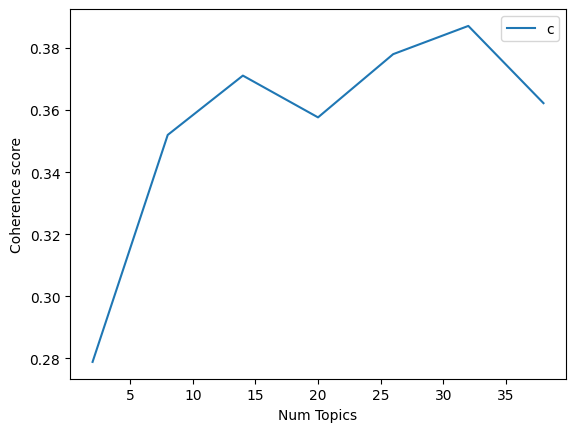

In [25]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=doc_tokenized)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5333,"nội_dung, dự_án, điều_chỉnh, thẩm_định, chủ_tr...","[điều, numbertoken, phạm_vi, điều_chỉnh]"
1,1,1.0,0.8133,"dự_án, nội_dung, giám_sát, vốn, chương_trình, ...","[điều, numbertoken, tiêu_chí, phân_loại, dự_án..."
2,2,3.0,0.5333,"dự_án, chương_trình, trách_nhiệm, đánh_giá, nộ...","[điều, numbertoken, hiệu_lực, thi_hành]"
3,3,0.0,0.0667,"giám_sát, thẩm_quyền, cơ_quan, thuộc, chương_t...","[điều, numbertoken, quy_định, chuyển_tiếp]"
4,4,5.0,0.8133,"dự_án, trong, chủ_trương, thực_hiện, tổ_chức, ...","[điều, numbertoken, điều_chỉnh, tiêu_chí, phân..."
5,5,6.0,0.3556,"nội_dung, giám_sát, cơ_quan, nhà_nước, vốn, qu...","[điều, numbertoken, nguyên_tắc, quản_lý, đầu_t..."
6,6,6.0,0.7667,"nội_dung, giám_sát, cơ_quan, nhà_nước, vốn, qu...","[điều, numbertoken, nội_dung, quản_lý, nhà_nướ..."
7,7,5.0,0.5333,"dự_án, trong, chủ_trương, thực_hiện, tổ_chức, ...","[điều, numbertoken, công_khai, minh_bạch, tron..."
8,8,1.0,0.9067,"dự_án, nội_dung, giám_sát, vốn, chương_trình, ...","[điều, numbertoken, chi_phí, lập, thẩm_định, t..."
9,9,14.0,0.6889,"giám_sát, dự_án, các, trách_nhiệm, chương_trìn...","[điều, numbertoken, các, hành_vi, bị, nghiêm_c..."


In [30]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.035585  0.135132       1        1  12.070404
4      0.004513  0.002960       2        1  10.312761
6     -0.075979  0.102431       3        1   9.990085
3      0.171922  0.059800       4        1   9.387199
2      0.070366 -0.003021       5        1   7.483526
0      0.103733 -0.065367       6        1   6.553538
14     0.130279  0.021215       7        1   6.470513
12    -0.242766 -0.014331       8        1   6.383769
9     -0.044438  0.017371       9        1   6.080468
1      0.046393  0.037006      10        1   5.882172
10     0.041121 -0.020858      11        1   5.490168
7     -0.030084  0.118177      12        1   4.163416
5      0.114898 -0.151256      13        1   4.155181
13    -0.047216 -0.160496      14        1   3.671233
8     -0.207155 -0.078764      15        1   1.905568, topic_info=          Term     Freq      Total Category  logprob  loglift
17   thẩm_định  50.0000  50.000000  Default  30.0000  30.0000
49    nhiệm_vụ  20.0000  20.000000  Default  29.0000  29.0000
40     cơ_quan  39.0000  39.000000  Default  28.0000  28.0000
57    giám_sát  46.0000  46.000000  Default  27.0000  27.0000
58   quyền_hạn  16.0000  16.000000  Default  26.0000  26.0000
..         ...      ...        ...      ...      ...      ...
20  chủ_trương   0.0491  33.796900  Topic15  -6.0958  -2.5739
52   thực_hiện   0.0491  19.282870  Topic15  -6.0958  -2.0127
19         các   0.0491  15.436364  Topic15  -6.0958  -1.7902
24    quốc_gia   0.0491  16.879781  Topic15  -6.0958  -1.8796
58   quyền_hạn   0.0491  16.282849  Topic15  -6.0958  -1.8436

[568 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
43        1  0.186172    báo_cáo
43        2  0.093086    báo_cáo
43        4  0.186172    báo_cáo
43        7  0.139629    báo_cáo
43        8  0.046543    báo_cáo
...     ...       ...        ...
28        1  0.107912  đối_tượng
28        2  0.215825  đối_tượng
28        6  0.107912  đối_tượng
28       11  0.215825  đối_tượng
28       12  0.215825  đối_tượng

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 5, 7, 4, 3, 1, 15, 13, 10, 2, 11, 8, 6, 14, 9])